In [3]:
from bluemath_tk.predictor.xwt import XWT

dwt = XWT(steps={}).load_model("outputs/dwt_model_aveiro_GOOD.pkl")
awt = XWT(steps={}).load_model("outputs/awt_model_aveiro.pkl")

2025-03-26 17:54:01,073 - XWT - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-26 17:54:01,086 - XWT - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


In [4]:
dwt_kma_bmus_df = dwt.kma_bmus.copy()
dwt_kma_bmus_df.index.name = "time"
dwt_kma_bmus_df.columns = ["bmus"]
dwt_kma_bmus_ds = dwt_kma_bmus_df.to_xarray()
dwt_kma_bmus_ds

<xarray.Dataset> Size: 367kB
Dimensions:  (time: 30592)
Coordinates:
  * time     (time) datetime64[ns] 245kB 1940-02-20 1940-02-21 ... 2023-11-22
Data variables:
    bmus     (time) int32 122kB 1 1 1 1 8 8 10 1 4 ... 12 12 23 23 23 2 7 7 24

In [5]:
covariates_ds = (
    awt.steps.get("pca")
    .pcs.resample(time="1D")
    .pad()
    .rename({"n_component": "n_covariates", "PCs": "cov_norm"})
    .drop(["stds", "kma_bmus"])
)
covariates_ds = (covariates_ds - covariates_ds.mean(dim="time")) / covariates_ds.std(
    dim="time"
)
covariates_ds["cov_names"] = (("n_covariates"), [f"PC{i}" for i in range(1, 4)])
covariates_ds

<xarray.Dataset> Size: 970kB
Dimensions:       (time: 30317, n_covariates: 3)
Coordinates:
  * time          (time) datetime64[ns] 243kB 1940-01-01 ... 2023-01-01
  * n_covariates  (n_covariates) int64 24B 0 1 2
Data variables:
    cov_norm      (time, n_covariates) float64 728kB -0.4951 2.177 ... 2.64
    cov_names     (n_covariates) <U3 36B 'PC1' 'PC2' 'PC3'

In [6]:
from bluemath_tk.teslakit.alr import ALR_WRP

alr_terms = {
    "mk_order": 3,
    "constant": True,
    "long_term": False,
    "seasonality": (True, [2, 4, 6]),
    "covariates": (
        True,
        covariates_ds.sel(time=dwt_kma_bmus_ds.time, method="nearest"),
    ),
}

alr_model = ALR_WRP(
    p_base="/home/tausiaj/GitHub-GeoOcean/BlueMath_notebooks/climate_services/MUSCLE.Aveiro/outputs/dwt_alr"
)
alr_model.SetFitData(
    cluster_size=dwt.num_clusters,
    xds_bmus_fit=dwt_kma_bmus_ds,
    d_terms_settings=alr_terms,
)
alr_model.FitModel(max_iter=1000)


Fitting autoregressive logistic model ...
Optimization done in 136.44 seconds



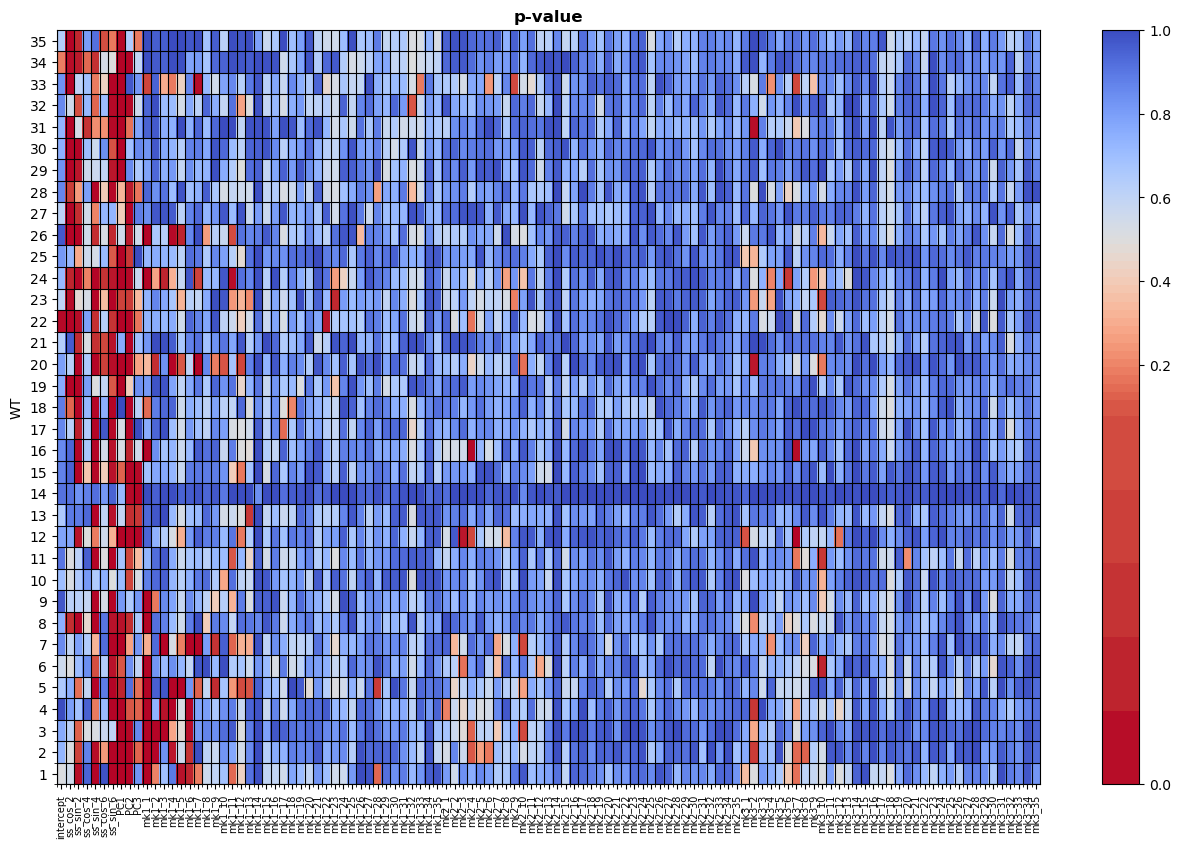

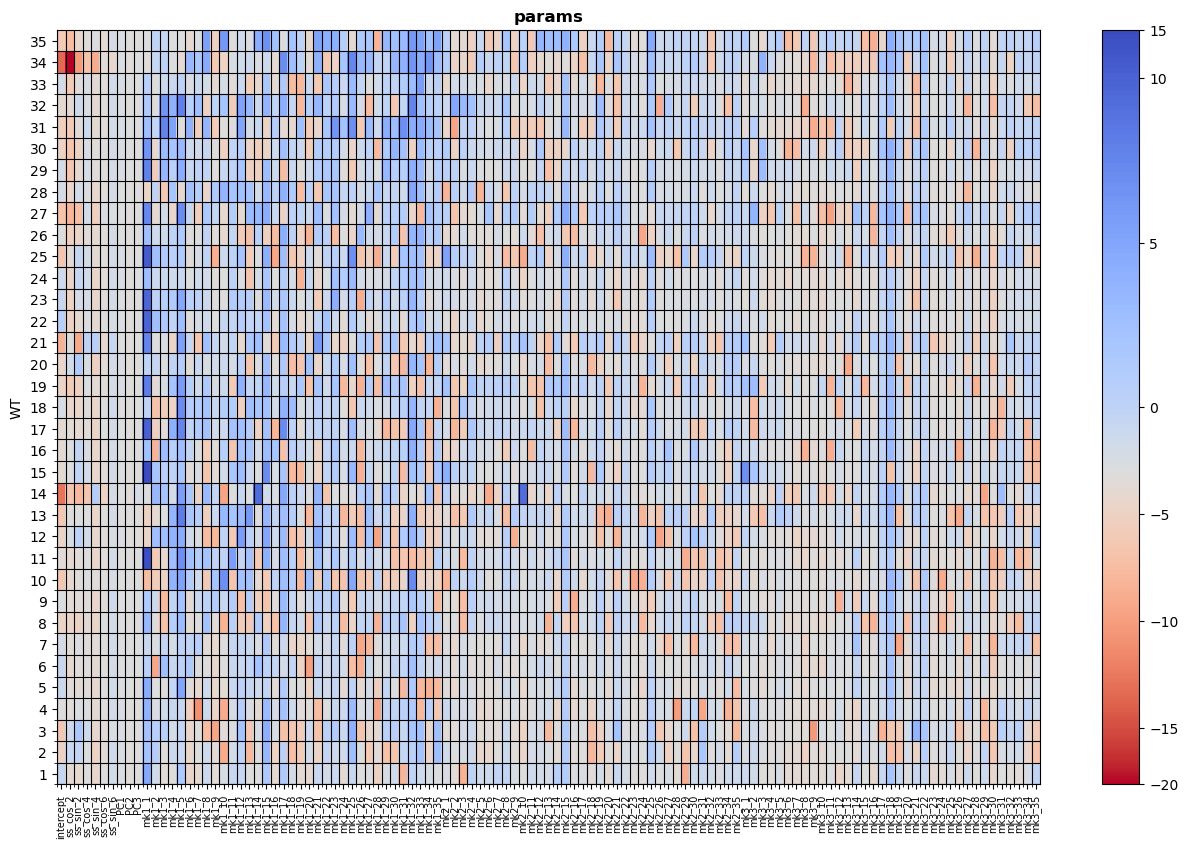

In [7]:
# Plot model p-values and params

alr_model.Report_Fit()

In [8]:
import xarray as xr

simulated_annual_PCs = (
    xr.open_dataset("outputs/awt_alr/simulated_PCs.nc").resample(time="1D").pad()
)
simulated_annual_PCs

<xarray.Dataset> Size: 89MB
Dimensions:     (time: 36891, n_sim: 100, n_covariates: 3)
Coordinates:
  * time        (time) datetime64[ns] 295kB 1999-01-01 1999-01-02 ... 2100-01-01
  * n_sim       (n_sim) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: n_covariates
Data variables:
    cov_values  (n_sim, time, n_covariates) float64 89MB ...

In [9]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate

# launch simulation
simulated_daily_bmus = alr_model.Simulate(
    num_sims=5,
    time_sim=simulated_annual_PCs.time.values,
    xds_covars_sim=simulated_annual_PCs,
)
simulated_daily_bmus

ALR model fit   : 1940-02-20 --- 2023-11-22
ALR model sim   : 1999-01-01 --- 2100-01-01

Launching 5 simulations...

Sim. Num. 005 (Covs. 005): 100%|██████████| 36888/36888 [00:16<00:00, 2213.47it/s]



<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36891, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 295kB 1999-01-01 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 1MB 1 1 1 1 1 1 1 1 ... 16 1 26 26 4 16 1 3
    ofbmus_sims  (time, n_sim) bool 184kB False False False ... False False

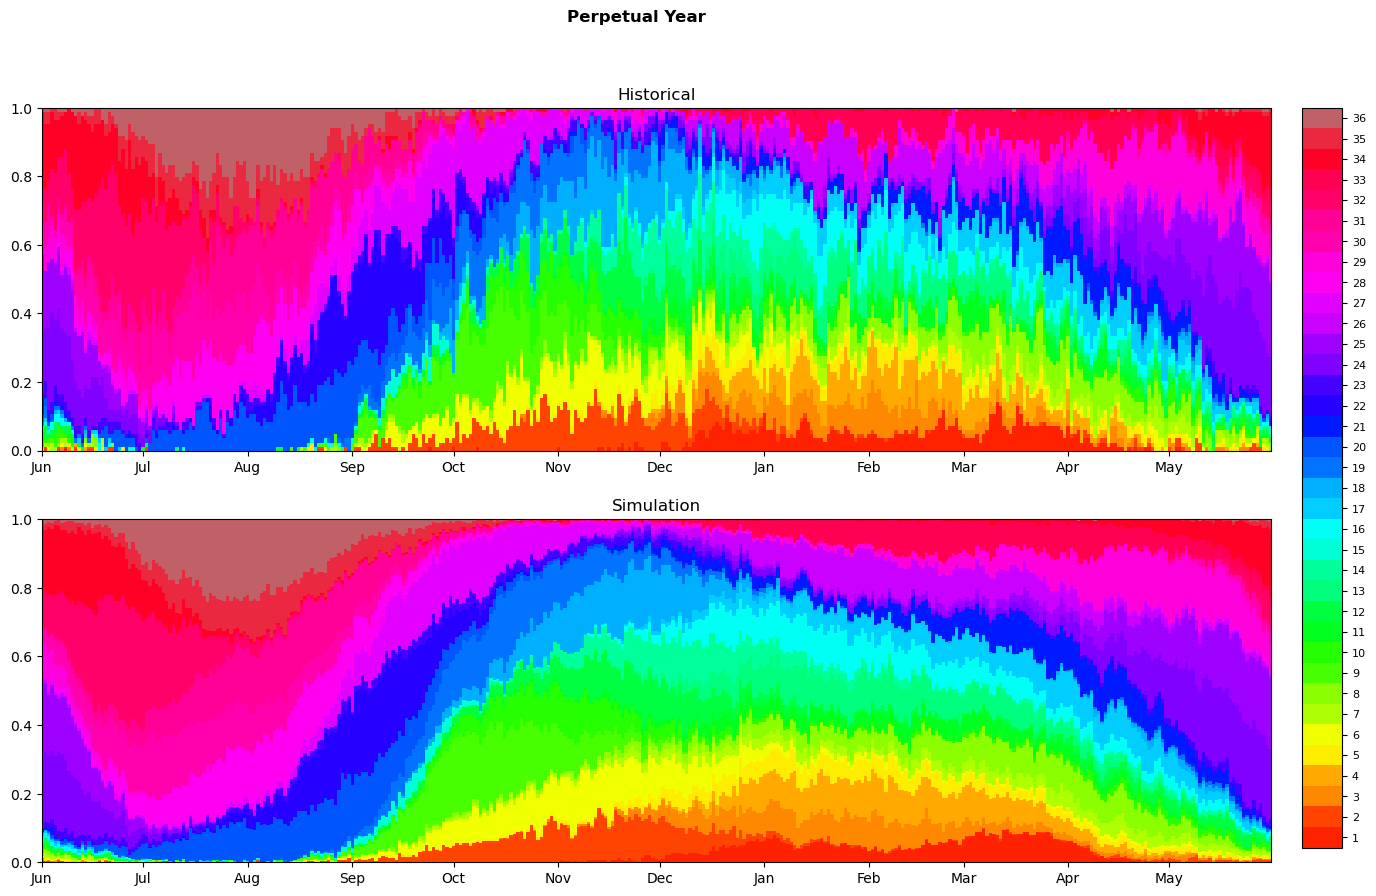

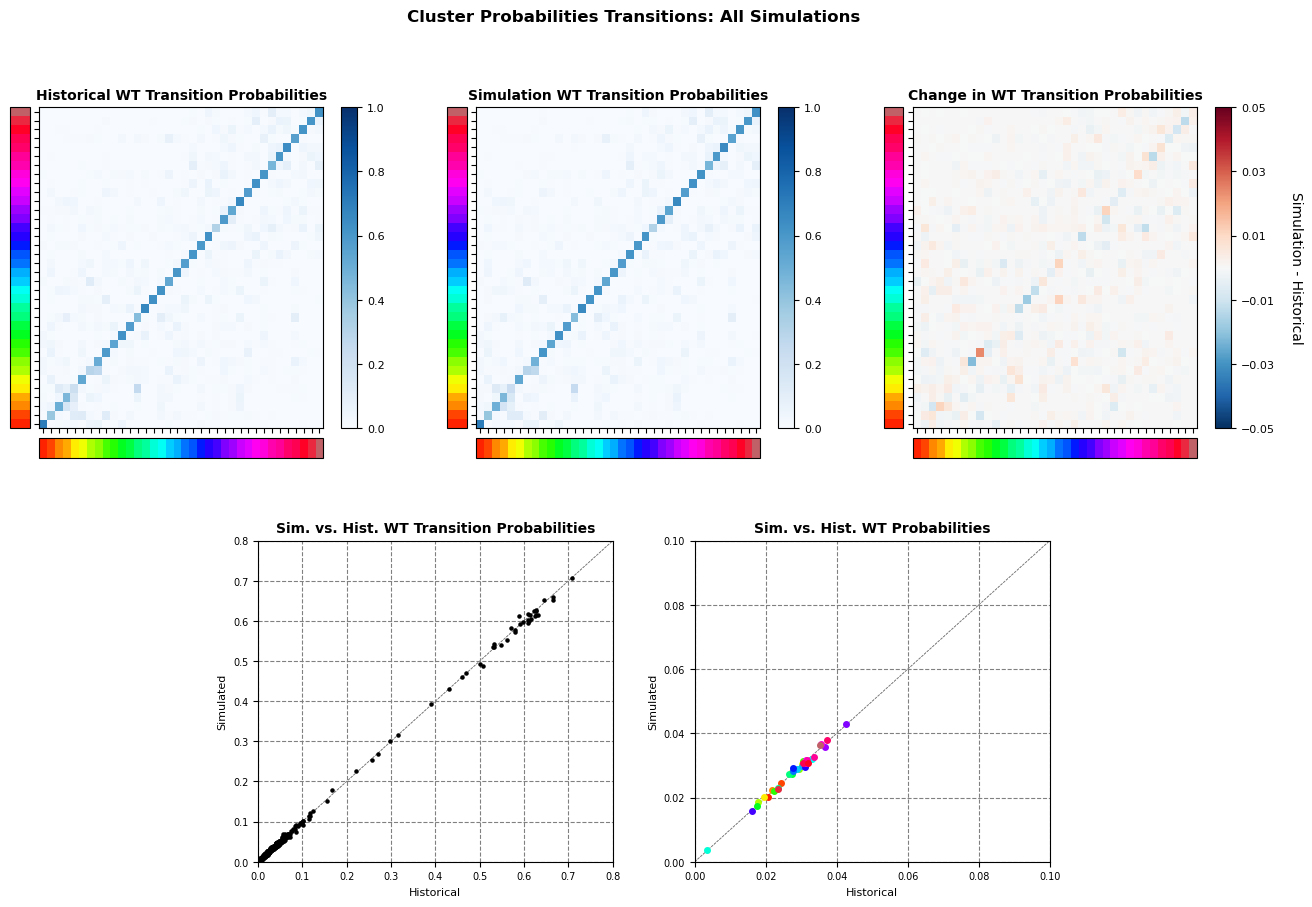

In [10]:
# show sim report

_fig = alr_model.Report_Sim(py_month_ini=6)